We will investigate the Elliptic dataset (available at https://www.kaggle.com/datasets/ellipticco/elliptic-data-set). This is the largest dataset concerning the Bitcoin transaction graph to date, and is provided by the firm Elliptic for use by researchers.

The dataset consists of a list of nodes and edges; the nodes represent transactions, and the edges represent transfers of Bitcoin from one transaction to another.


The dataset splits the nodes into three classes: 



1.   Illicit transactions
2.   Licit transactions
3.   Unknown transactions



Each node has 166 features, which unfortulately cannot be described due to IP rights issues--it's enough to say that they represent various metrics on number of neighbours, or average amount sent, and so on.

Each node has a `timestamp` feature, an integer from 1 to 49--the timestamps are evenly spaced in ~2 week intervals. Each node is part of a connected component of transactions occurring at roughly the same time, so that no two nodes with different timestamps are connected by an edge. 

(source: https://www.kaggle.com/datasets/ellipticco/elliptic-data-set)

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!wget -q https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
#!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.ml.linalg import Vectors
import numpy as np 
from pyspark.sql import SparkSession #to make dataframe from rdd easily
import time

sc = SparkContext(appName="bitcoinFraud", master="local[*]")
spark_session = SparkSession(sc)

We load the datasets into some RDD's. We load the labels and the features into separate dataframes, rename some columns, and join the labels to the features.

In [ ]:
# perform some transformations on the features RDD, so that each row has shape
# (tx_id, label, [features_list])

feats_raw = sc.textFile(
    "/content/drive/MyDrive/elliptic_txs_features.csv"
).map(
    lambda x: list(map(float, x.split(",")))
).map(
    lambda x: (int(x[0]), int(x[1]), Vectors.dense(np.array(x[2:])))
).cache()

labels_raw = sc.textFile(
    "/content/drive/MyDrive/elliptic_txs_classes.csv"
).cache()

#remove first entry of the rdd
first_entry = labels_raw.first()
labels_raw = labels_raw.filter(
    lambda x:x != first_entry
).cache()


#define a helper function to relabel 'unknown' transactions as -1
def relabel(x):
  if x[1] == 'unknown':
    out = ( x[0], float(-1) )
  elif x[1] == '2': # if licit
    out =  ( x[0], float(0) )
  else: # if illicit
    out = ( x[0], float(1) )
  return out

labels_raw = labels_raw.map(
    # split the line by commas, turn the first entry into a float
    lambda x: (int(x.split(",")[0]), x.split(",")[1])
).map(
    relabel
).cache()

Let's look at the prevalence of each class:

In [ ]:
feats_df = feats_raw.toDF(['id', 'timestep', 'features'])
labels_df = labels_raw.toDF(['id', 'label'])

data = labels_df.join(
    feats_df,
    how='inner',
    on='id'
).sort(
    'timestep'
).cache()


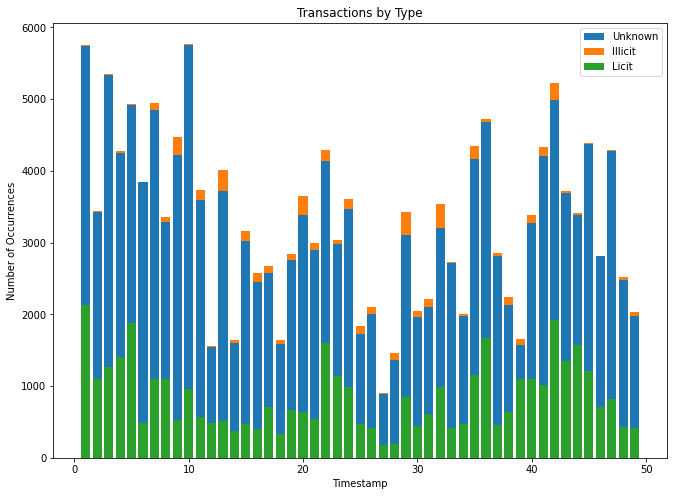

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

grouped = data.groupBy('timestep', 'label').count()
illicit = grouped.filter('label==1.0').select('timestep', 'count').toPandas().to_numpy()
licit = grouped.filter('label==0.0').select('timestep', 'count').toPandas().to_numpy()
unknown = grouped.filter('label==-1.0').select('timestep', 'count').toPandas().to_numpy()

hist_data = np.column_stack((illicit[:, 0], illicit[:, 1], licit[:, 1], unknown[:, 1]))
plt.figure(figsize=(11, 8))


plt.bar(licit[:, 0], unknown[:, 1], label='Unknown')
plt.bar(licit[:, 0], illicit[:, 1], bottom=unknown[:, 1], label='Illicit')
plt.bar(licit[:, 0], licit[:, 1], label="Licit" )

plt.xlabel("Timestamp")
plt.ylabel("Number of Occurrences")
plt.title("Transactions by Type")
plt.legend()
plt.show()


We see that most of the nodes are classed as unknown, with a tiny minority being classed as illicit. 

In [ ]:
# join the two dataframes and filter out the uncategorized instances.

data = labels_df.join(
    feats_df,
    how='inner',
    on='id'
).sort(
    'timestep'
).filter(
    'label >= 0'
).cache()

# Remove all columns except label and features.
data = data.select(data['label'], data['features'])


We have gathered the labelled data in the above dataframe. 
In a 2019 ArXiv paper by Mark Weber et al, *Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics*
(https://arxiv.org/abs/1908.02591), researchers used this dataset to train a model for illicit transaction detection. They used a variety of models, but found that a random forest model trained with default parameters in *scikit learn* had the best performance. 

We will attempt to train a random forest classifier on the same dataset using the Spark ML library, and compare our results with those in the paper.

First, we must import some libraries:

In [ ]:
# code adapted from https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

As in the paper by Weber et al., we split the data into train (70%) and test (%30) sets. Instances with timestamp $\leq 34$ will go to the training set, and the rest will go to the test set.



In [ ]:
# code adapted from https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

#need to make label indexers. This gives an index to each possible label in the dataset, 0.0 for most frequent, then 1.0, and so on
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
#need to make feature indexer--automatically identifies categorical features and indexes them. Here all features are real-valued.
featureIndexer = VectorIndexer(
    inputCol='features', outputCol='indexedFeatures', maxCategories=2
).fit(data)


# split the dataset into train and test sets. 
train_df = data.filter(
    "timestep <= 34"
).cache()

test_df = data.filter(
    "timestep > 34"
).cache()



We are now ready to define our model and begin training.

In [ ]:
# code credit:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

# define the random forest model, using
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# we need to convert the indexed labels back to the original labels
labelConverter = IndexToString(
    inputCol='prediction', 
    outputCol='predictedLabel',
    labels=labelIndexer.labels
)

# we construct a pipeline, which chains together the indexing, training, and
# de-indexing
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

#train the model
model = pipeline.fit(train_df)


The model is now trained--time to evaluate the performance of the model!

In [ ]:
# code credit:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

import matplotlib.pyplot as plt
# define function to return false positives and true positives by threshold
def get_roc(rdd, thresh):
  '''
  rdd: an RDD with rows of shape (label, predictedLabel, prob_of_illicit)
  thresh: a float in [0, 1]
  '''
  fp = rdd.filter(lambda x: x[0]==0.0 and x[2] > thresh ).count()
  tp = rdd.filter(lambda x: x[0]==1.0 and x[2] > thresh).count()
  fn = rdd.filter(lambda x: x[0]==1.0 and x[2] <= thresh).count()
  tn = rdd.filter(lambda x: x[0]==0.0 and x[2] <= thresh).count()

  fpr = fp/(fp + tn)
  tpr = tp/(tp + fn)

  return fpr, tpr

def get_metrics(rdd):
  '''
  rdd: an RDD with rows of shape (label, predictedLabel, prob_of_illicit)
  '''
  fp = rdd.filter(lambda x: x[0]==0.0 and x[1]== 1.0 ).count()
  tp = rdd.filter(lambda x: x[0]==1.0 and x[1]== 1.0 ).count()
  fn = rdd.filter(lambda x: x[0]==1.0 and x[1]== 0.0).count()
  tn = rdd.filter(lambda x: x[0]==0.0 and x[1]== 0.0).count()

  fpr = fp/(fp + tn)
  tpr = tp/(tp + fn)

  return fpr, tpr, {'fp': fp, 'tp':tp, 'fn':fn, 'tn':tn}


# Make predictions.
predictions = model.transform(test_df)
# select relevant columns from the DataFrame, make it into an RDD
pred_and_label = predictions.select(
    'label', 'predictedLabel', 'probability'
).rdd.map(
    lambda x: ( x.__getitem__('label'),
                float(x.__getitem__('predictedLabel')),
                x.__getitem__('probability')[1]
               )
).cache()


thresholds = np.linspace(0, 1, 20)

fpr_list = []
tpr_list = []

for t in thresholds:
  fpr, tpr = get_roc(pred_and_label, t)
  fpr_list.append(fpr)
  tpr_list.append(tpr)



Text(0.5, 1.0, 'ROC Curve, Bitcoin Fraud Detection')

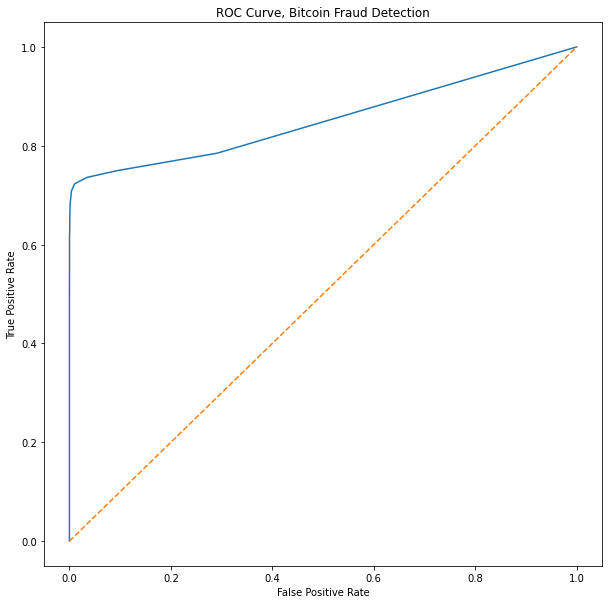

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(fpr_list, tpr_list,'-', thresholds, thresholds, '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve, Bitcoin Fraud Detection')

In [ ]:
fpr, tpr, con = get_metrics(pred_and_label)

prec = con['tp']/(con['tp'] + con['fp'])
f1 = 2*con['tp']/(2*con['tp'] + con['fp'] + con['fn'])

print('Precision = %g' % prec)
print("True Positive Rate = %g" % tpr)
print("False Positive Rate = %g" % fpr)
print("F1 Score = %g" %f1)


Precision = 0.989766
True Positive Rate = 0.625115
False Positive Rate = 0.000449092
F1 Score = 0.766271


That's pretty cute, but the true positive rate is rather low. This could be due to the class imbalance in the dataset. Let's look at the distribution of classes again:

In [ ]:
data.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|42019|
|  1.0| 4545|
+-----+-----+



There are about 10 times more licit examples than illicit ones--this is likely the cause of the low true positive rate. 

We can try to address this by augmenting the dataset by adding illicit examples to the dataset. By adding some small amount of random noise to the feature set of an illicit example, we can generate an example which, hopefully, will have similar properties to the real illicit example, which we label as also illicit. 

We will generate some dummy positive examples for each real one, and then add this to the training set to better balance the classes of the training data.

In [ ]:
from pyspark.sql import Row

aug_num = 6
eps = 0.01
def add_noise(row):
  '''
  Takes an RDD row, 
  '''
  feats = row[1].toArray()
  label = row[0]
  rand = np.random.normal(size = (aug_num, len(feats)))* eps
  noisy = feats + rand
  out = [(label, noisy[i]) for i in range(aug_num)]
  return out

new_pos_instances = train_df.filter(
    'label==1.0'
).rdd.map(
  add_noise
).flatMap(
    lambda x:x
).map(
    lambda x: Row(features=Vectors.dense(x[1]), label=x[0])
).toDF(['features', 'label']).select('label', 'features')

augmented_train_df = train_df.union(new_pos_instances).cache()



We now have a training set with more balanced classes:

In [ ]:
augmented_train_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|26432|
|  1.0|24234|
+-----+-----+



In [ ]:
# code credit:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

# define the random forest model, using
rf_aug = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# we need to convert the indexed labels back to the original labels
labelConverter = IndexToString(
    inputCol='prediction', 
    outputCol='predictedLabel',
    labels=labelIndexer.labels
)

# we construct a pipeline, which chains together the indexing, training, and
# de-indexing
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf_aug, labelConverter])

#train the model
model_aug = pipeline.fit(augmented_train_df)


We trained a new model on the augmented data. Let's see how it does:

In [ ]:
# Make predictions.
predictions_aug = model_aug.transform(test_df)
# select relevant columns from the DataFrame, make it into an RDD
pred_and_label_aug = predictions_aug.select(
    'label', 'predictedLabel', 'probability'
).rdd.map(
    lambda x: ( x.__getitem__('label'),
                float(x.__getitem__('predictedLabel')),
                x.__getitem__('probability')[1]
               )
).cache()

In [ ]:
fpr_list_aug = []
tpr_list_aug = []

for t in thresholds:
  fpr_aug, tpr_aug = get_roc(pred_and_label_aug, t)
  fpr_list_aug.append(fpr_aug)
  tpr_list_aug.append(tpr_aug)

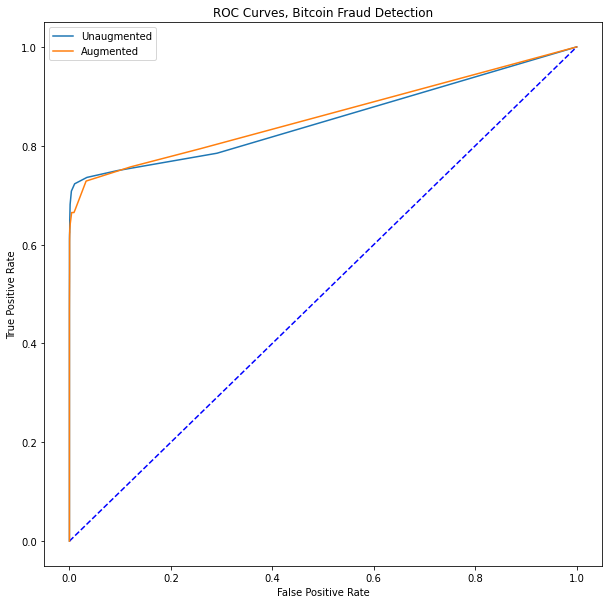

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(fpr_list, tpr_list, label='Unaugmented')
plt.plot(thresholds, thresholds, 'b--')
plt.plot(fpr_list_aug, tpr_list_aug, label="Augmented")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curves, Bitcoin Fraud Detection')
plt.legend()

In [ ]:
fpr_aug, tpr_aug, con_aug = get_metrics(pred_and_label_aug)

prec_aug = con_aug['tp']/(con_aug['tp'] + con_aug['fp'])
f1_aug = 2*con_aug['tp']/(2*con_aug['tp'] + con_aug['fp'] + con_aug['fn'])

print('Precision = %g' % prec_aug)
print("True Positive Rate = %g" % tpr_aug)
print("False Positive Rate = %g" % fpr_aug)
print("F1 Score = %g" %f1_aug)

Precision = 0.985486
True Positive Rate = 0.626962
False Positive Rate = 0.00064156
F1 Score = 0.766366


It looks like simple data augmentation does not help much here--perhaps it was wishful thinking!

Decision trees work as follows (source: https://spark.apache.org/docs/latest/mllib-decision-tree.html): The dataset $D$ is recursively partitioned into two sets, $L$ and $R$, on the split point $s$. The algorithm greedily chooses a split point which maximizes the information gain

$$ IG(D, s) = impurity(D) - impurity(L) - impurity(R)$$
where $impurity(\cdot)$ is the so-called Gini impurity
$$ G(S) = \sum_{i=1}^C f_i(1-f_i)$$

where $C$ is the number of class labels in the dataset, and $f_i$ is the frequency of class $i$ in the set $S$. 

The following reweighting strategy, from Ting (2002)*, weighs instances of a class inversely proportional to the prevalence of that class in the dataset, so that misclassification of the minority class incurs a larger penalty. We introduce, for the class $j$, $N$ being the total number of instances, $N_j$ being the number of instances of the class $j$, the weights

$$ w_j = \frac{NC_j}{\sum_{i}N_iC_i}$$
where C_i is the 'cost' of misclassifying an instance of class $j$. Here, we chose $C_0 = 0.3$, $C_1 = 0.7$--this was somewhat arbitrary, but is meant to reflect that it's worse to miss a sketchy transaction than to falsely accuse someone. 

For a weighted decision tree, we instead compute the weighted Gini impurity

$$ G_w(S) = \sum_{i=1}^C w_if_i(1-f_i)$$

which, intuitively, compensates for the dearth of positive samples.

* \*K.M. Ting, “An Instance-Weighting Method to Induce CostSensitive Trees,” IEEE Trans. Knowledge and Data Eng., vol. 14,
no. 3, pp. 659-665, May/June 2002.*

In [ ]:
# code credit:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
# https://www.datatrigger.org/post/spark_3_weighted_random_forest/

from pyspark.sql.functions import col
from pyspark.sql.functions import when

c = np.array([0.3, 0.7])

n = np.array([data.filter('label==0').count(), data.filter('label==1').count()])
N = np.sum(n)

w = [ N*c[j]/np.sum(n * c) for j in range(len(c))]

# attach class weights to the data
train_df_weighted = train_df.withColumn("weight", when(col("label") ==1, w[1]).otherwise(w[0]))

In [ ]:
# define the random forest model, using weights this time
rf_weighted = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", weightCol='weight', numTrees=100)

# we need to convert the indexed labels back to the original labels
labelConverter = IndexToString(
    inputCol='prediction', 
    outputCol='predictedLabel',
    labels=labelIndexer.labels
)

# we construct a pipeline, which chains together the indexing, training, and
# de-indexing
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf_weighted, labelConverter])

#train the model
model_weighted = pipeline.fit(train_df_weighted)

In [ ]:
# Make predictions.
predictions_weighted = model_weighted.transform(test_df)
# select relevant columns from the DataFrame, make it into an RDD
pred_and_label_weighted = predictions_weighted.select(
    'label', 'predictedLabel', 'probability'
).rdd.map(
    lambda x: ( x.__getitem__('label'),
                float(x.__getitem__('predictedLabel')),
                x.__getitem__('probability')[1]
               )
).cache()

In [ ]:
fpr_list_weighted = []
tpr_list_weighted = []

for t in thresholds:
  fpr_weighted, tpr_weighted = get_roc(pred_and_label_weighted, t)
  fpr_list_weighted.append(fpr_weighted)
  tpr_list_weighted.append(tpr_weighted)

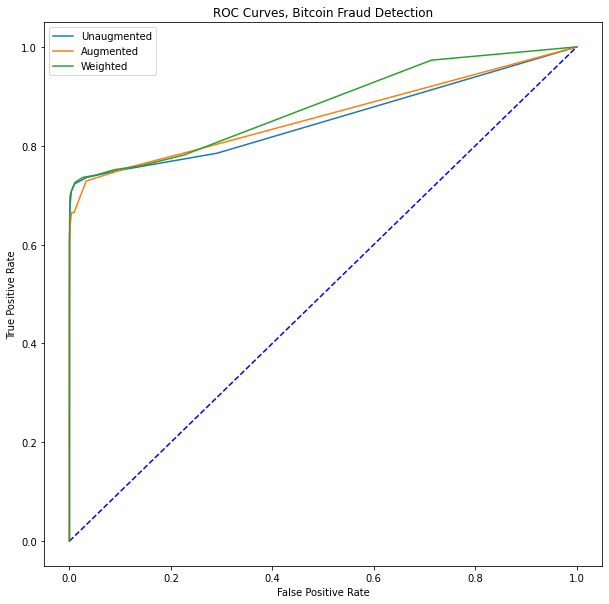

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(fpr_list, tpr_list, label='Unaugmented')
plt.plot(thresholds, thresholds, 'b--')
plt.plot(fpr_list_aug, tpr_list_aug, label="Augmented")
plt.plot(fpr_list_weighted, tpr_list_weighted, label="Weighted")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curves, Bitcoin Fraud Detection')
plt.legend()

In [ ]:
fpr_weighted, tpr_weighted, con_weighted = get_metrics(pred_and_label_weighted)

prec_weighted = con_weighted['tp']/(con_weighted['tp'] + con_weighted['fp'])
f1_weighted = 2*con_weighted['tp']/(2*con_weighted['tp'] + con_weighted['fp'] + con_weighted['fn'])

print('Precision = %g' % prec_weighted)
print("True Positive Rate = %g" % tpr_weighted)
print("False Positive Rate = %g" % fpr_weighted)
print("F1 Score = %g" %f1_weighted)

Precision = 0.990642
True Positive Rate = 0.684211
False Positive Rate = 0.000449092
F1 Score = 0.809394


As we can see from the results, the weighted random forest performed the best out of all the models; the false positive rate for the model is at least as good as for the baseline, with modest improvements in precision, true positive rate, and F1 score. 